# GEM Data Hackathon - Weighted Analysis

This notebook conducts a proper weighted analysis of the GEM data for the Butler Institute Hackathon 2025, applying survey weights for accurate population estimates.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Make plots larger and more readable
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Load and Examine the Data

The data has already been processed with R, with numeric codes converted to readable labels, and missing values properly handled.

In [2]:
# Load the data
data = pd.read_csv("Hackathon_GEM_Data_FULL.csv")

# Display basic info about the dataset
print(f"Dataset shape: {data.shape} (rows, columns)")
print("\nBasic dataset information:")
data.info()

Dataset shape: (15868, 36) (rows, columns)

Basic dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15868 entries, 0 to 15867
Data columns (total 36 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   weight                                   15868 non-null  float64
 1   new_entrepreneur                         15868 non-null  object 
 2   established_entrepreneur                 15868 non-null  object 
 3   knows_entrepreneur                       15761 non-null  object 
 4   local_opportunity                        13316 non-null  object 
 5   entrepreneurial_skill                    14795 non-null  object 
 6   fear_of_failure                          15120 non-null  object 
 7   wants_entrepreneurship                   12070 non-null  object 
 8   respects_entrepreneurship                12082 non-null  object 
 9   follows_entrepreneurship                 1241

In [3]:
# Display the first few rows to understand the data structure
data.head()

,weight,new_entrepreneur,established_entrepreneur,knows_entrepreneur,local_opportunity,entrepreneurial_skill,fear_of_failure,wants_entrepreneurship,respects_entrepreneurship,follows_entrepreneurship,...,new_entrepreneur_owners,new_entrepreneur_external_sales,established_entrepreneur_external_sales,new_entrepreneur_innovation,year,new_entrepreneur_local_innovation,new_entrepreneur_employees,established_entrepreneur_employees,race,region
0,0.674020,No,No,No,No,No,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,White,Great Lakes
1,0.674020,No,No,No,NaN,No,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,White,Great Lakes
2,0.814409,No,Yes,No,No,Yes,Yes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,1.0,White,Great Lakes
3,1.289586,No,No,No,NaN,Yes,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,Black,Great Lakes
4,0.963587,No,No,No,NaN,No,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,Black,Southeast


## 2. Understanding and Using Survey Weights

Survey weights are essential for accurate population-level analyses. The `weight` column in the GEM dataset should be used to account for sampling design and to make the sample representative of the whole population.

### Why Weights Matter

- **Representativeness**: Some demographic groups may be under or overrepresented in the sample
- **Precision**: Weights help correct for sampling bias
- **Population Inferences**: Using weights allows us to make accurate statements about the entire population

Let's implement helper functions for our weighted analyses:

In [5]:
# Define helper functions for weighted analyses
def calculate_weighted_percentage(data, column, value):
    """Calculate weighted percentage for a categorical variable."""
    mask = data[column] == value
    if mask.sum() == 0:
        return 0
    weighted_count = (mask * data['weight']).sum()
    total_weight = data['weight'].sum()
    return (weighted_count / total_weight) * 100

def weighted_crosstab(data, row_var, col_var, normalize='index'):
    """Create a weighted cross-tabulation between two variables."""
    return pd.crosstab(
        data[row_var], 
        data[col_var],
        values=data['weight'],
        aggfunc='sum',
        normalize=normalize
    ) * 100 if normalize else 1
    
def weighted_mean(data, value_var, weight_var='weight'):
    """Calculate weighted mean of a variable."""
    # Drop NaN values for proper calculation
    clean_data = data[[value_var, weight_var]].dropna()
    return np.average(clean_data[value_var], weights=clean_data[weight_var])

def weighted_median(data, value_var, weight_var='weight'):
    """Calculate weighted median of a variable."""
    # Drop NaN values
    clean_data = data[[value_var, weight_var]].dropna()
    if len(clean_data) == 0:
        return np.nan
        
    # Sort by value
    sorted_data = clean_data.sort_values(by=value_var)
    
    # Calculate cumulative weights
    cumsum = sorted_data[weight_var].cumsum()
    cutoff = sorted_data[weight_var].sum() / 2.0
    
    # Find the median
    return sorted_data[value_var].iloc[np.searchsorted(cumsum, cutoff)]

## 3. Data Type Conversion

In [6]:
# Make a copy of the dataset to work with
df = data.copy()

# Convert yes/no columns to categorical data type
yes_no_columns = [
    'new_entrepreneur', 'established_entrepreneur', 'knows_entrepreneur',
    'local_opportunity', 'entrepreneurial_skill', 'fear_of_failure',
    'future_startup', 'discontinued_business', 'is_investor'
]

for col in yes_no_columns:
    if col in df.columns:
        df[col] = pd.Categorical(df[col])

# Convert other categorical columns
categorical_columns = [
    'gender', 'age_range', 'household_income', 'education',
    'new_entrepreneur_industry', 'established_entrepreneur_industry',
    'new_entrepreneur_innovation', 'new_entrepreneur_local_innovation',
    'race', 'region', 'discontinued_business_continuation',
    'investment', 'investment_relationship',
    'wants_entrepreneurship', 'respects_entrepreneurship', 'follows_entrepreneurship'
]

for col in categorical_columns:
    if col in df.columns:
        df[col] = pd.Categorical(df[col])

# Convert year to integer
if 'year' in df.columns:
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df['year'] = df['year'].astype('Int64')  # nullable integer type
    
# Convert numeric columns to appropriate types
numeric_columns = [
    'weight', 'household_size', 'new_entrepreneur_new_jobs',
    'established_entrepreneur_new_jobs', 'established_entrepreneur_owners',
    'new_entrepreneur_owners', 'new_entrepreneur_employees',
    'established_entrepreneur_employees'
]

for col in numeric_columns:
    if col in df.columns:
        # Use 'coerce' to handle non-numeric values by setting them to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Check the data types after conversion
df.dtypes

weight                                      float64
new_entrepreneur                           category
established_entrepreneur                   category
knows_entrepreneur                         category
local_opportunity                          category
entrepreneurial_skill                      category
fear_of_failure                            category
wants_entrepreneurship                     category
respects_entrepreneurship                  category
follows_entrepreneurship                   category
future_startup                             category
discontinued_business                      category
discontinued_business_continuation         category
is_investor                                category
investment                                 category
investment_relationship                    category
gender                                     category
age_range                                  category
household_size                              float64
household_in

## 4. Basic Descriptive Statistics - Weighted vs. Unweighted

In [7]:
# Compare weighted and unweighted proportions for key entrepreneurial variables
key_vars = ['new_entrepreneur', 'established_entrepreneur', 'knows_entrepreneur', 
            'entrepreneurial_skill', 'fear_of_failure', 'future_startup']

results = []
for var in key_vars:
    if var in df.columns:
        # Calculate unweighted percentage
        unweighted_pct = df[var].value_counts(normalize=True).get('Yes', 0) * 100
        
        # Calculate weighted percentage
        weighted_pct = calculate_weighted_percentage(df, var, 'Yes')
        
        # Store results
        results.append({
            'Variable': var,
            'Unweighted %': unweighted_pct,
            'Weighted %': weighted_pct,
            'Difference': weighted_pct - unweighted_pct
        })

# Display comparison
pd.DataFrame(results).set_index('Variable')

,Unweighted %,Weighted %,Difference
Variable,,,
new_entrepreneur,14.563902,14.654924,0.091022
established_entrepreneur,9.030754,8.776537,-0.254216
knows_entrepreneur,43.404606,43.250499,-0.154107
entrepreneurial_skill,59.607976,54.994025,-4.613950
fear_of_failure,41.507937,39.693679,-1.814257
future_startup,18.281453,18.001888,-0.279564


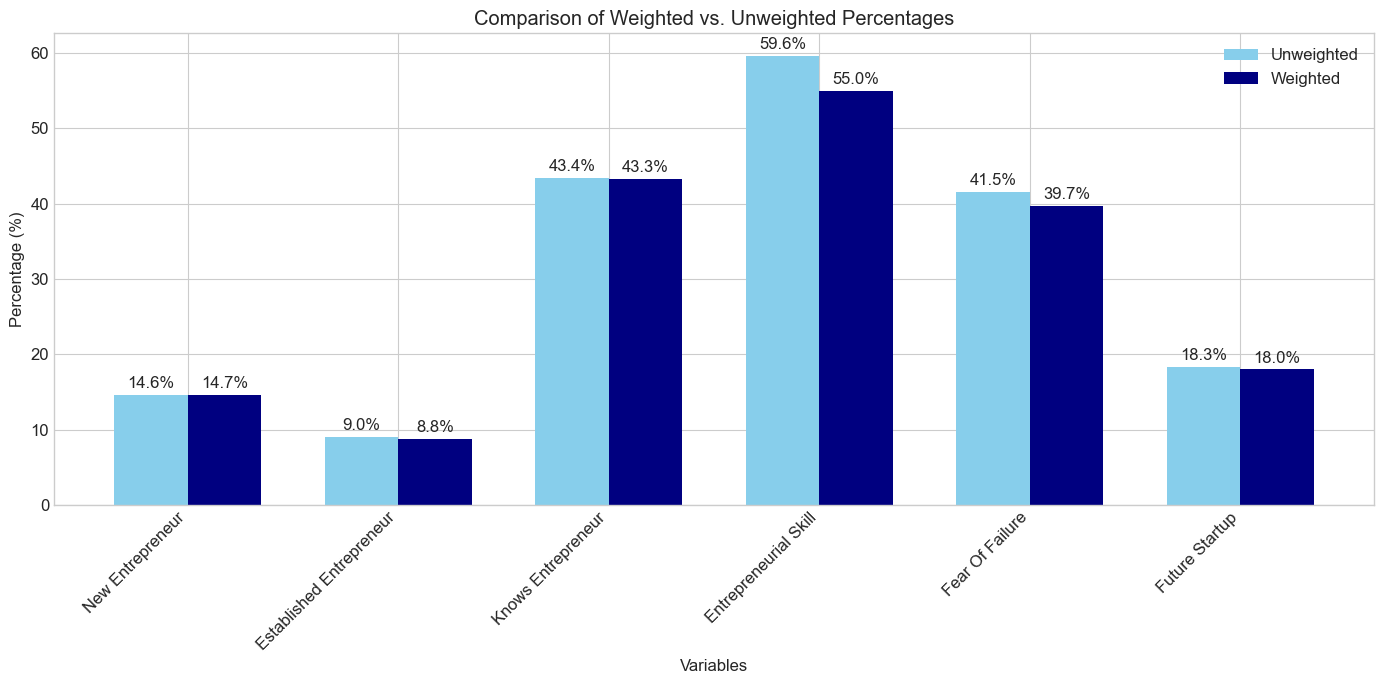

In [8]:
# Create a comparison visualization
if results:
    comp_df = pd.DataFrame(results).set_index('Variable')
    
    plt.figure(figsize=(14, 7))
    
    x = np.arange(len(comp_df.index))
    width = 0.35
    
    plt.bar(x - width/2, comp_df['Unweighted %'], width, label='Unweighted', color='skyblue')
    plt.bar(x + width/2, comp_df['Weighted %'], width, label='Weighted', color='navy')
    
    plt.xlabel('Variables')
    plt.ylabel('Percentage (%)')
    plt.title('Comparison of Weighted vs. Unweighted Percentages')
    plt.xticks(x, [var.replace('_', ' ').title() for var in comp_df.index], rotation=45, ha='right')
    plt.legend()
    
    # Add value labels
    for i, v in enumerate(comp_df['Unweighted %']):
        plt.text(i - width/2, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')
    
    for i, v in enumerate(comp_df['Weighted %']):
        plt.text(i + width/2, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

## 5. Entrepreneurship by Demographics (Weighted Analysis)

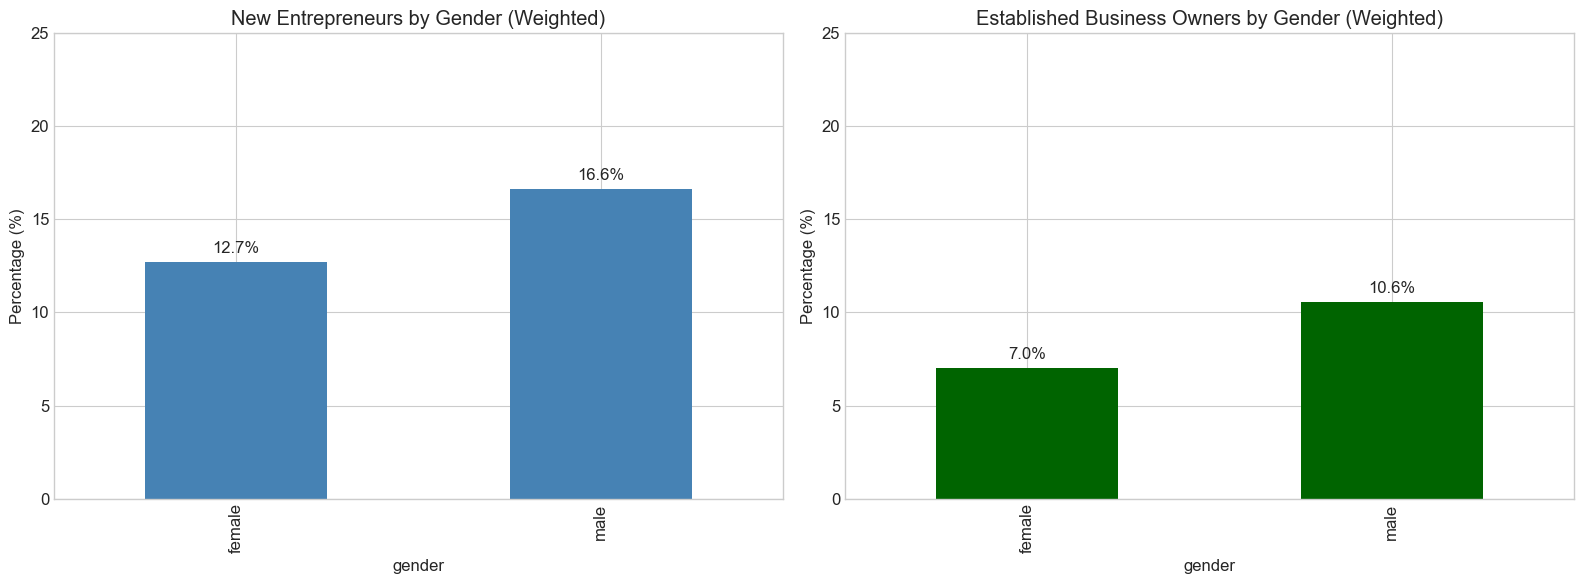

In [9]:
# Entrepreneurship by gender (weighted analysis)
gender_tea_weighted = weighted_crosstab(df, 'gender', 'new_entrepreneur')
gender_eb_weighted = weighted_crosstab(df, 'gender', 'established_entrepreneur')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot new entrepreneurs by gender
gender_tea_weighted['Yes'].plot(kind='bar', ax=ax[0], color='steelblue')
ax[0].set_title('New Entrepreneurs by Gender (Weighted)')
ax[0].set_ylabel('Percentage (%)')
ax[0].set_ylim(0, 25)  # Adjust as needed based on data
for i, v in enumerate(gender_tea_weighted['Yes']):
    ax[0].text(i, v + 0.5, f'{v:.1f}%', ha='center')

# Plot established business owners by gender
gender_eb_weighted['Yes'].plot(kind='bar', ax=ax[1], color='darkgreen')
ax[1].set_title('Established Business Owners by Gender (Weighted)')
ax[1].set_ylabel('Percentage (%)')
ax[1].set_ylim(0, 25)  # Adjust as needed based on data
for i, v in enumerate(gender_eb_weighted['Yes']):
    ax[1].text(i, v + 0.5, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()

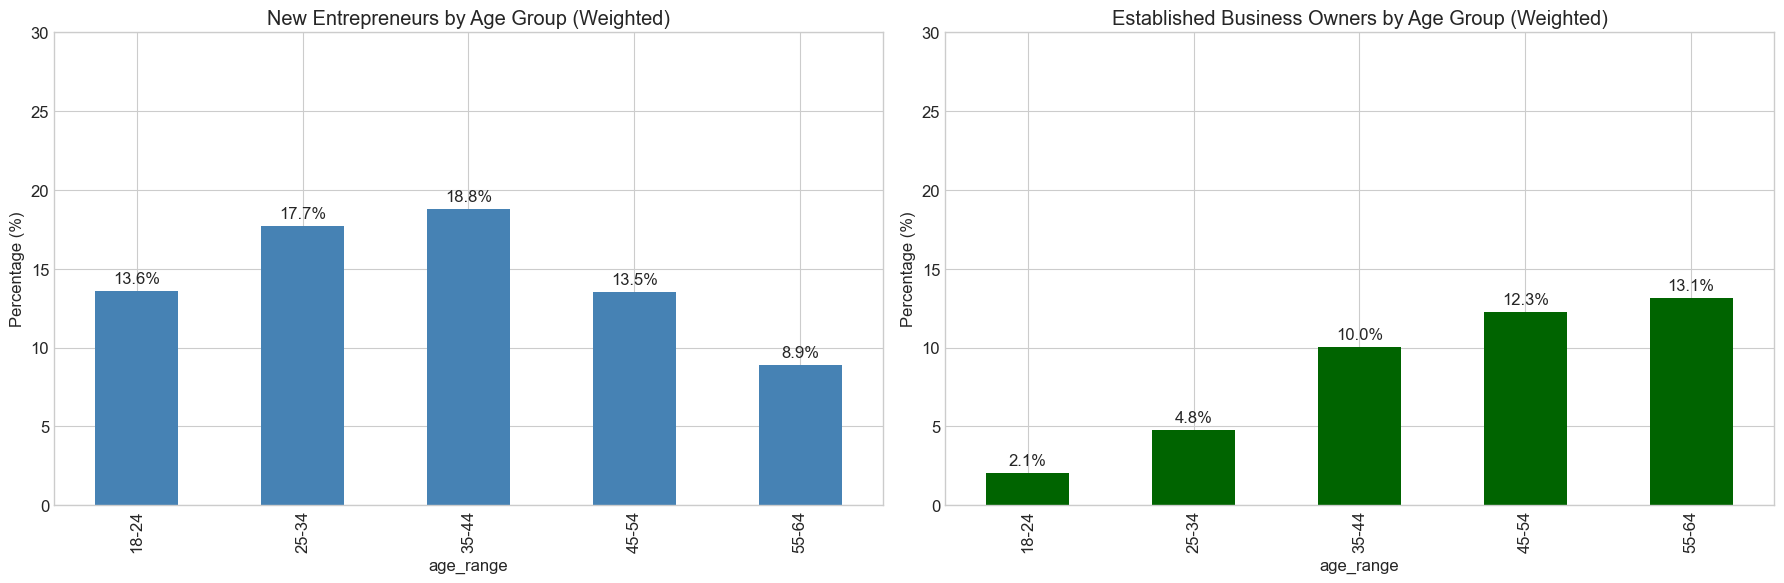

In [10]:
# Entrepreneurship by age range (weighted analysis)
age_tea_weighted = weighted_crosstab(df, 'age_range', 'new_entrepreneur')
age_eb_weighted = weighted_crosstab(df, 'age_range', 'established_entrepreneur')

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Plot new entrepreneurs by age
age_tea_weighted['Yes'].plot(kind='bar', ax=ax[0], color='steelblue')
ax[0].set_title('New Entrepreneurs by Age Group (Weighted)')
ax[0].set_ylabel('Percentage (%)')
ax[0].set_ylim(0, 30)  # Adjust as needed based on data
for i, v in enumerate(age_tea_weighted['Yes']):
    ax[0].text(i, v + 0.5, f'{v:.1f}%', ha='center')

# Plot established business owners by age
age_eb_weighted['Yes'].plot(kind='bar', ax=ax[1], color='darkgreen')
ax[1].set_title('Established Business Owners by Age Group (Weighted)')
ax[1].set_ylabel('Percentage (%)')
ax[1].set_ylim(0, 30)  # Adjust as needed based on data
for i, v in enumerate(age_eb_weighted['Yes']):
    ax[1].text(i, v + 0.5, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()

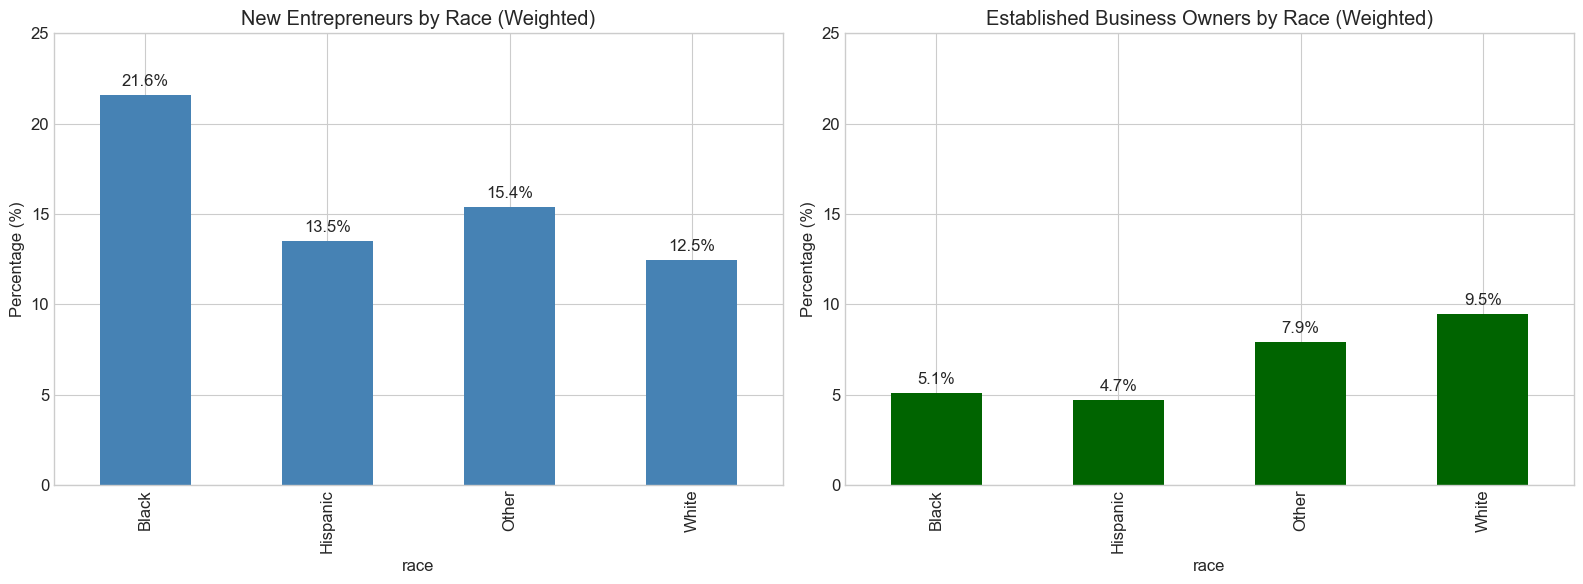

In [11]:
# Entrepreneurship by race (weighted analysis)
race_tea_weighted = weighted_crosstab(df, 'race', 'new_entrepreneur')
race_eb_weighted = weighted_crosstab(df, 'race', 'established_entrepreneur')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot new entrepreneurs by race
race_tea_weighted['Yes'].plot(kind='bar', ax=ax[0], color='steelblue')
ax[0].set_title('New Entrepreneurs by Race (Weighted)')
ax[0].set_ylabel('Percentage (%)')
ax[0].set_ylim(0, 25)  # Adjust as needed based on data
for i, v in enumerate(race_tea_weighted['Yes']):
    ax[0].text(i, v + 0.5, f'{v:.1f}%', ha='center')

# Plot established business owners by race
race_eb_weighted['Yes'].plot(kind='bar', ax=ax[1], color='darkgreen')
ax[1].set_title('Established Business Owners by Race (Weighted)')
ax[1].set_ylabel('Percentage (%)')
ax[1].set_ylim(0, 25)  # Adjust as needed based on data
for i, v in enumerate(race_eb_weighted['Yes']):
    ax[1].text(i, v + 0.5, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()

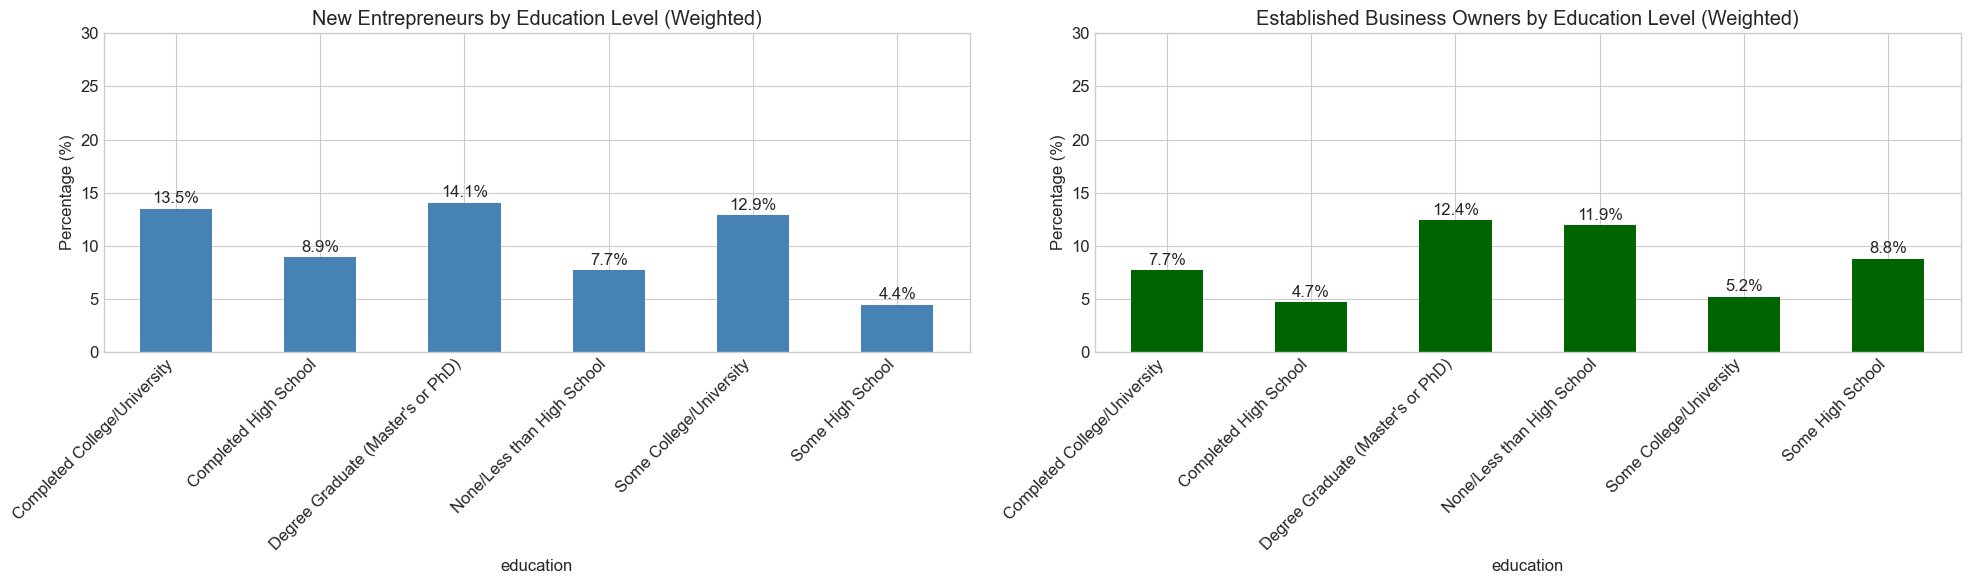

In [12]:
# Entrepreneurship by education level (if data is available)
if 'education' in df.columns and df['education'].notna().sum() > 0:
    # Create weighted crosstabs
    edu_tea_weighted = weighted_crosstab(df, 'education', 'new_entrepreneur')
    edu_eb_weighted = weighted_crosstab(df, 'education', 'established_entrepreneur')
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))
    
    # Plot new entrepreneurs by education
    edu_tea_weighted['Yes'].plot(kind='bar', ax=ax[0], color='steelblue')
    ax[0].set_title('New Entrepreneurs by Education Level (Weighted)')
    ax[0].set_ylabel('Percentage (%)')
    ax[0].set_ylim(0, 30)  # Adjust as needed
    plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    for i, v in enumerate(edu_tea_weighted['Yes']):
        ax[0].text(i, v + 0.5, f'{v:.1f}%', ha='center')
    
    # Plot established business owners by education
    edu_eb_weighted['Yes'].plot(kind='bar', ax=ax[1], color='darkgreen')
    ax[1].set_title('Established Business Owners by Education Level (Weighted)')
    ax[1].set_ylabel('Percentage (%)')
    ax[1].set_ylim(0, 30)  # Adjust as needed
    plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    for i, v in enumerate(edu_eb_weighted['Yes']):
        ax[1].text(i, v + 0.5, f'{v:.1f}%', ha='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("Education data is not available or has too many missing values.")

## 6. Weighted Entrepreneurship Trends Over Time

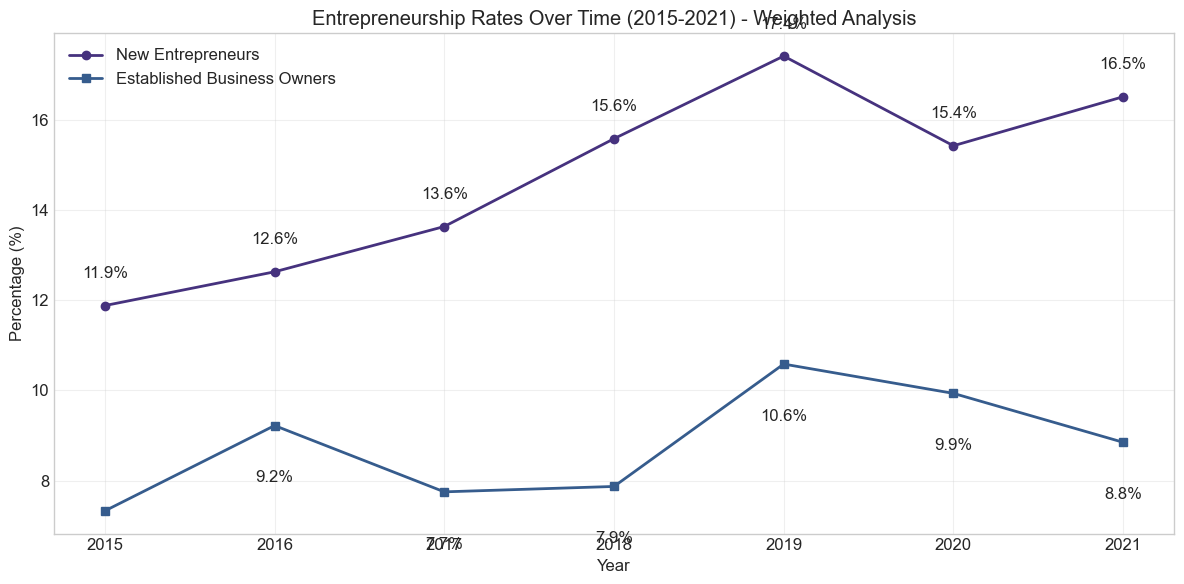

In [13]:
# Calculate weighted entrepreneurship rates by year
year_tea_weighted = weighted_crosstab(df, 'year', 'new_entrepreneur')
year_eb_weighted = weighted_crosstab(df, 'year', 'established_entrepreneur')

plt.figure(figsize=(12, 6))
plt.plot(year_tea_weighted.index, year_tea_weighted['Yes'], marker='o', linewidth=2, label='New Entrepreneurs')
plt.plot(year_eb_weighted.index, year_eb_weighted['Yes'], marker='s', linewidth=2, label='Established Business Owners')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.title('Entrepreneurship Rates Over Time (2015-2021) - Weighted Analysis')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(year_tea_weighted.index)

# Add percentage labels
for i, (tea_val, eb_val) in enumerate(zip(year_tea_weighted['Yes'], year_eb_weighted['Yes'])):
    plt.annotate(f'{tea_val:.1f}%', (year_tea_weighted.index[i], tea_val + 0.3), textcoords="offset points", 
                 xytext=(0,10), ha='center')
    plt.annotate(f'{eb_val:.1f}%', (year_eb_weighted.index[i], eb_val - 0.8), textcoords="offset points", 
                 xytext=(0,-15), ha='center')

plt.tight_layout()
plt.show()

## 7. Factors Associated with Entrepreneurship (Weighted Analysis)

/var/folders/4c/d6mxj1_s0qzf8gdb0j1j9dsc0000gn/T/ipykernel_39332/2813789298.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crosstab_weighted.index, y=crosstab_weighted['Yes'], ax=axes[i], palette='Blues_r')
/var/folders/4c/d6mxj1_s0qzf8gdb0j1j9dsc0000gn/T/ipykernel_39332/2813789298.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=crosstab_weighted.index, y=crosstab_weighted['Yes'], ax=axes[i], palette='Blues_r')
/var/folders/4c/d6mxj1_s0qzf8gdb0j1j9dsc0000gn/T/ipykernel_39332/2813789298.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  

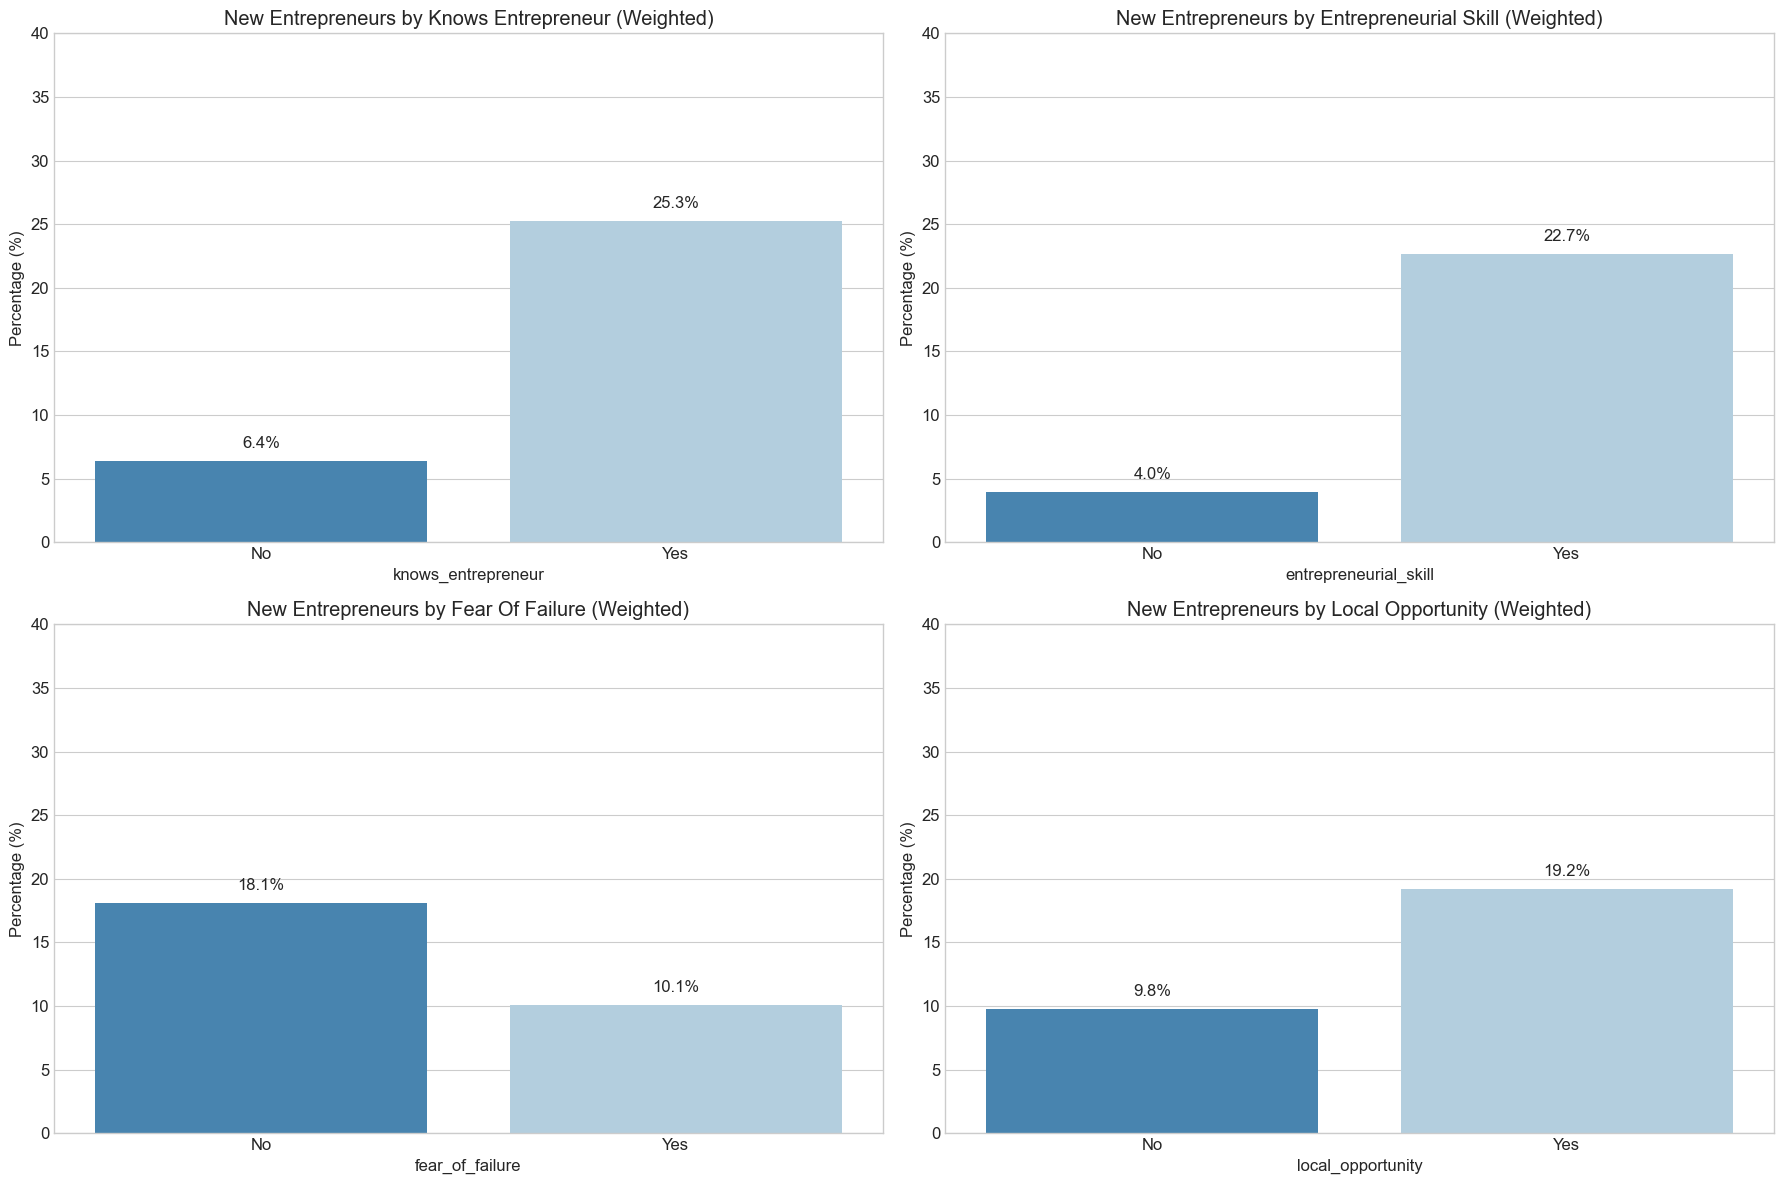

In [14]:
# Define factors to explore
factors = ['knows_entrepreneur', 'entrepreneurial_skill', 'fear_of_failure', 'local_opportunity']

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for i, factor in enumerate(factors):
    if factor in df.columns:
        # Calculate weighted percentage of entrepreneurs by factor
        crosstab_weighted = weighted_crosstab(df, factor, 'new_entrepreneur')
        
        # Skip factors with insufficient data
        if 'Yes' not in crosstab_weighted.columns or crosstab_weighted['Yes'].empty:
            continue
            
        # Create the plot
        sns.barplot(x=crosstab_weighted.index, y=crosstab_weighted['Yes'], ax=axes[i], palette='Blues_r')
        axes[i].set_title(f'New Entrepreneurs by {factor.replace("_", " ").title()} (Weighted)')
        axes[i].set_ylabel('Percentage (%)')
        axes[i].set_ylim(0, 40)  # Adjust as needed
        
        # Add value labels
        for j, v in enumerate(crosstab_weighted['Yes']):
            axes[i].text(j, v + 1, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()

## 8. Regional Patterns of Entrepreneurship (Weighted Analysis)

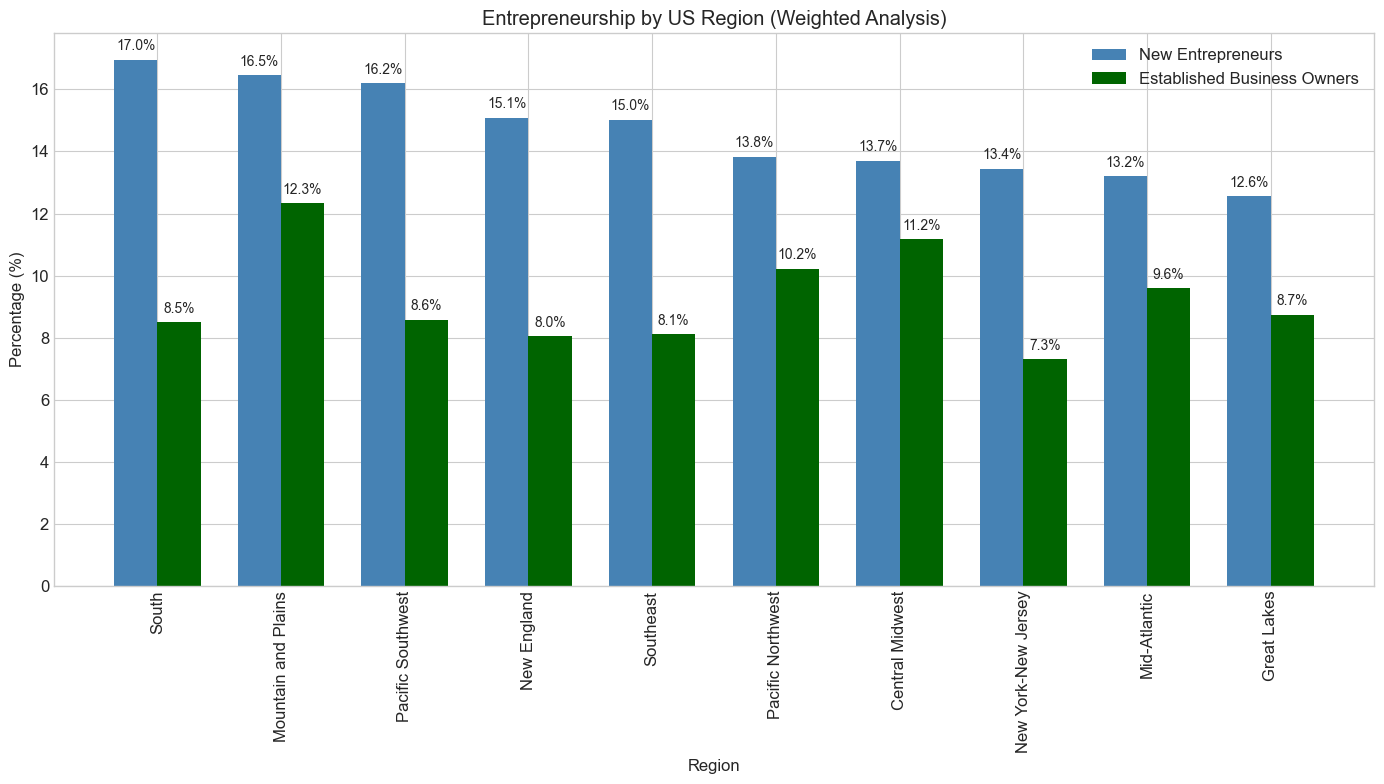

In [15]:
# Calculate weighted entrepreneurship rates by region
region_tea_weighted = weighted_crosstab(df, 'region', 'new_entrepreneur')
region_eb_weighted = weighted_crosstab(df, 'region', 'established_entrepreneur')

# Sort by new entrepreneur percentage
region_tea_weighted = region_tea_weighted.sort_values('Yes', ascending=False)

# Plot the results
plt.figure(figsize=(14, 8))
bar_width = 0.35
index = np.arange(len(region_tea_weighted.index))
plt.bar(index, region_tea_weighted['Yes'], bar_width, label='New Entrepreneurs', color='steelblue')
plt.bar(index + bar_width, region_eb_weighted.loc[region_tea_weighted.index]['Yes'], bar_width, 
        label='Established Business Owners', color='darkgreen')

plt.xlabel('Region')
plt.ylabel('Percentage (%)')
plt.title('Entrepreneurship by US Region (Weighted Analysis)')
plt.xticks(index + bar_width / 2, region_tea_weighted.index, rotation=90)
plt.legend()

# Add percentage labels
for i, v in enumerate(region_tea_weighted['Yes']):
    plt.text(i, v + 0.3, f'{v:.1f}%', ha='center', fontsize=10)
    
for i, v in enumerate(region_eb_weighted.loc[region_tea_weighted.index]['Yes']):
    plt.text(i + bar_width, v + 0.3, f'{v:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 9. Weighted Analysis of Industry Distribution (if available)

/var/folders/4c/d6mxj1_s0qzf8gdb0j1j9dsc0000gn/T/ipykernel_39332/3634536462.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  industry_weights = new_entrepreneurs.groupby('new_entrepreneur_industry')['weight'].sum()


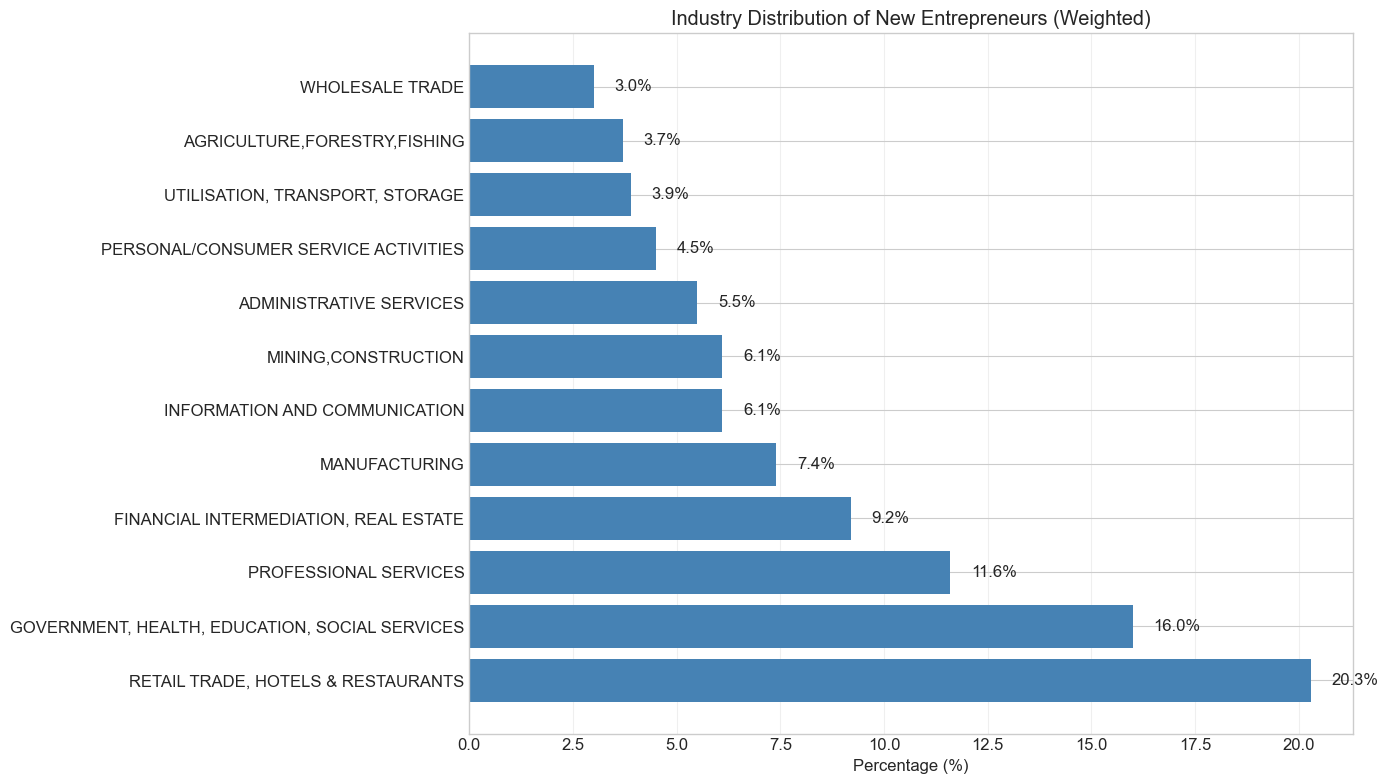

In [16]:
# Check if we have industry data
if 'new_entrepreneur_industry' in df.columns and df['new_entrepreneur_industry'].notna().sum() > 0:
    # Industry distribution for new entrepreneurs (weighted analysis)
    # First, filter to only new entrepreneurs
    new_entrepreneurs = df[df['new_entrepreneur'] == 'Yes']
    
    # Calculate weighted industry distribution
    industry_weights = new_entrepreneurs.groupby('new_entrepreneur_industry')['weight'].sum()
    total_weight = industry_weights.sum()
    industry_pct = (industry_weights / total_weight * 100).round(1)
    
    # Sort and filter out missing/not classified
    industry_pct = industry_pct.sort_values(ascending=False)
    if 'NOT CLASSIFIED/MISSING' in industry_pct.index:
        industry_pct = industry_pct[industry_pct.index != 'NOT CLASSIFIED/MISSING']
    
    # Create the plot
    plt.figure(figsize=(14, 8))
    bars = plt.barh(industry_pct.index, industry_pct, color='steelblue')
    plt.xlabel('Percentage (%)')
    plt.title('Industry Distribution of New Entrepreneurs (Weighted)')
    plt.grid(axis='x', alpha=0.3)
    
    # Add percentage labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width}%',
                ha='left', va='center')
    
    plt.tight_layout()
    plt.show()
else:
    print("Industry data not available or completely missing in this dataset.")

## 10. Weighted Analysis of Business Size and Employment

In [17]:
# Get available metrics on business size and employment
business_size_vars = [
    var for var in [
        'new_entrepreneur_employees', 'established_entrepreneur_employees',
        'new_entrepreneur_owners', 'established_entrepreneur_owners',
        'new_entrepreneur_new_jobs', 'established_entrepreneur_new_jobs'
    ] if var in df.columns
]

# Create a summary of weighted business metrics
business_metrics = []

for var in business_size_vars:
    # Determine which type of entrepreneur this variable applies to
    if 'new_entrepreneur' in var:
        # Filter for new entrepreneurs only
        ent_data = df[df['new_entrepreneur'] == 'Yes'].copy()
        ent_type = 'New Entrepreneurs'
    else:
        # Filter for established entrepreneurs only
        ent_data = df[df['established_entrepreneur'] == 'Yes'].copy()
        ent_type = 'Established Business Owners'
    
    # Skip if we don't have enough data
    if ent_data[var].notna().sum() < 10:
        continue
        
    # Calculate weighted statistics
    try:
        w_mean = weighted_mean(ent_data, var)
        w_median = weighted_median(ent_data, var)
        
        business_metrics.append({
            'Metric': var.replace('_', ' ').title(),
            'Entrepreneur Type': ent_type,
            'Weighted Mean': round(w_mean, 1),
            'Weighted Median': round(w_median, 1),
            'N': ent_data[var].notna().sum()
        })
    except Exception as e:
        print(f"Error calculating weighted statistics for {var}: {e}")

# Display the metrics
if business_metrics:
    pd.DataFrame(business_metrics).set_index(['Metric', 'Entrepreneur Type'])
else:
    print("Not enough data available for business size/employment analysis.")

## 11. Creating a Weighted Profile of Entrepreneurs

Let's create comprehensive profiles of new and established entrepreneurs based on weighted analysis.

In [ ]:
# Function to create weighted profiles
def create_entrepreneur_profile(data, entrepreneur_type):
    """Create a weighted profile of entrepreneurs based on demographics."""
    if entrepreneur_type == 'new':
        type_col = 'new_entrepreneur'
        title = 'New Entrepreneurs'
    else:
        type_col = 'established_entrepreneur'
        title = 'Established Business Owners'
    
    # Filter for the entrepreneur type
    entrepreneurs = data[data[type_col] == 'Yes']
    
    # Calculate demographic distributions with weights
    profile = {}
    
    # Gender distribution
    if 'gender' in entrepreneurs.columns:
        gender_dist = entrepreneurs.groupby('gender')['weight'].sum() / entrepreneurs['weight'].sum() * 100
        profile['Gender'] = gender_dist.to_dict()
    
    # Age distribution
    if 'age_range' in entrepreneurs.columns:
        age_dist = entrepreneurs.groupby('age_range')['weight'].sum() / entrepreneurs['weight'].sum() * 100
        profile['Age'] = age_dist.to_dict()
    
    # Race distribution
    if 'race' in entrepreneurs.columns:
        race_dist = entrepreneurs.groupby('race')['weight'].sum() / entrepreneurs['weight'].sum() * 100
        profile['Race'] = race_dist.to_dict()
    
    # Education (if available)
    if 'education' in entrepreneurs.columns and entrepreneurs['education'].notna().sum() > 0:
        edu_dist = entrepreneurs.groupby('education')['weight'].sum() / entrepreneurs['weight'].sum() * 100
        profile['Education'] = edu_dist.to_dict()
    
    # Industry (if available)
    industry_col = f"{entrepreneur_type}_entrepreneur_industry"
    if industry_col in entrepreneurs.columns and entrepreneurs[industry_col].notna().sum() > 0:
        ind_dist = entrepreneurs.groupby(industry_col)['weight'].sum() / entrepreneurs['weight'].sum() * 100
        profile['Industry'] = ind_dist.to_dict()
    
    # Region
    if 'region' in entrepreneurs.columns:
        region_dist = entrepreneurs.groupby('region')['weight'].sum() / entrepreneurs['weight'].sum() * 100
        profile['Region'] = region_dist.to_dict()
    
    return profile, title

# Create profiles for both types of entrepreneurs
new_profile, new_title = create_entrepreneur_profile(df, 'new')
established_profile, est_title = create_entrepreneur_profile(df, 'established')

# Display the profiles
print(f"Weighted Profile of {new_title}:")
for category, dist in new_profile.items():
    print(f"\n{category} Distribution:")
    # Display top 5 for each category to keep it clean
    sorted_dist = {k: v for k, v in sorted(dist.items(), key=lambda item: item[1], reverse=True)}
    for key, value in list(sorted_dist.items())[:5]:  # Top 5
        print(f"  {key}: {value:.1f}%")

print(f"\n\nWeighted Profile of {est_title}:")
for category, dist in established_profile.items():
    print(f"\n{category} Distribution:")
    # Display top 5 for each category to keep it clean
    sorted_dist = {k: v for k, v in sorted(dist.items(), key=lambda item: item[1], reverse=True)}
    for key, value in list(sorted_dist.items())[:5]:  # Top 5
        print(f"  {key}: {value:.1f}%")

## 12. Export Cleaned Dataset for Further Analysis

In [ ]:
# Save the processed dataframe to a new CSV file
df.to_csv('GEM_Data_Processed_Weighted.csv', index=False)
print("Processed data saved to 'GEM_Data_Processed_Weighted.csv'")